# 前処理大全

# 第一章 前処理とは

### データ分析の３つの前処理
- 表やグラフ作成用の前処理
- 教師なし学習へ入力するための前処理
- 教師あり学習へ入力するための前処理

### 前処理の流れ  
#### 1 データ構造を対象とした処理:大きなデータを扱うので、SQLが有利。  
- 対象データの抽出や結合、集約など  
 
#### 2 データ内容を対象とした処理：値の修正などのため、python有利。  
- データ内容の変更や、欠損値の補完など  
→ 集計やグラフの描写に使用  
- 機械学習モデルのために変換  
→ 教師なし学習用データ  
    
#### 3 データ構造を対象とした処理:機械学習用のライブラリの多いpythonを使用。  
- 学習、テストデータの分割  
→ 教師あり学習用データ  

## 第二章 抽出
データサイズを小さくするメリットは多いので、必要なデータのみを抽出するようにする。

### 注意事項
- iloc、ixなど値で指定する方法は不推奨、locや配列に文字列を使用する事を推奨。
- indexが無い場合、条件指定時に全探索する事になる。indexがあれば、必要範囲の指定となるので処理速度が向上。
- 条件指定抽出は、query関数が一番視認性が良いので推奨。
- データ量を指定の数に減らせるsample関数は重要であるが、指定する項目の選択によってはデータ割合に支障をきたすので注意が必要。

# 第三章 集約

集約方法は大きく分けると２つの方法がある  
- groupby    : 条件表現が豊富、但し記述量が多い。
- Window関数  : SQLが簡単に書けてオススメ！！ グループ毎に並び替えて順位づけする事に長けている。

**注意事項**  
- 集約処理とwindow関数の実行を同時にはできない。（SQLはできる)


### aggが便利
- agg({"指定先1":処理内容1,"指定先2":処理内容})と記述するだけで、複数の処理を行ってくれる。 
- １つの処理の時には、記述量が増えるので使わない。

# 第四章 結合

### マスターテーブルとレコードテーブル
- マスターテーブルは、顧客の情報などの共通情報を保管しており、顧客IDを持っている。
- レコードテーブルは、商品情報や店舗情報など様々な種類がある。

レコードテーブルにも顧客IDを所持するものもあり、マスターテーブルと結合することで、顧客情報の紐付けができる。

### 注意事項  
結合前になるべく不要なもの除くために抽出しておく。  

### 過去データの取扱　　
- 結合対象の期間を絞る。
- 結合した過去データに集約関数を利用する。 window関数が最適、但しpythonは実装されてないのでrolling関数を利用する。  
  rolling: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html

# 第五章 分割  
SQLでの作業は全く効率的でないためしない事。

## 時系列データにおける処理
- 単純な交差検証は有効ではない。未来のデータが混じっている可能性がある。
- 上記の対策として、期間をスライドさせたり、期間を追加していく検証方法が有効。  
- 期間を追加して行く場合は、追加する時期によりデータ量が変わってくるので、データ量の増加に伴う精度の関係も把握する必要がある。

**注意事項**
- pythonには時系列データを簡単に扱えるライブラリは無い。

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("awesomebook/data/month_mst.csv")
df["year_month"] = df["year_num"].astype(str) + "-" + df["month_num"].astype(str)
df["year_month"] = df["year_month"].sort_values(ascending=True)
df.sort_values(by="year_month")


train_window_start = 1
train_window_end   = 24
horizon = 12
skip    = 12

while True:
    test_window_end = train_window_end + horizon
    train = df[train_window_start:train_window_end]
    test  = df[(train_window_end + 1):test_window_end]
    if test_window_end >= len(df.index):
        break

    train_window_start += skip
    train_window_end += skip

# 第六章 生成

## 不均等データの調整

障害でないデータに対して、障害データが極端に少ないケースを不均等と言う。
不均等なデータは機械学習の予測精度が下がる要因となる可能性が多い。

## 不均等なデータへの対策
- 機械学習のモデル制作時に重みを与える。
- データを操作して不均等な状態を解除する。  
  -少ないデータを増やす : オーバーサンプリング  
  -多いデータを減らす   : アンダーサンプリング  
  -この両方を行う方法
  
## アンダーサンプリング
多い方のデータを減らすだけなので、簡単に実装出来ます。。  
但し、データを減らす事は勿体無いので、基本的にはオーバーサンプリングを行います。  
オーバーサンプリングで過学習を起こしそうな場合に、両方行うようにする事が望ましい。

## オーバーサンプリング  
データを増やす時に使う、増やす手法としてSMOTEが使いやすい。  
SMOTEは、障害データとその選択候補となるデータの中間に新たなデータを作る手法。

In [2]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(k_neighbors=5, random_state=1)

# 第七章 展開

## 横持ちへの変換
pythonでは、集約処理と横持ち変換が同時にできる**ピボットテーブル**という非常に強力な関数がある。  
indexにはキー要素、columnsには要素の種類をあらわすキー値、valuesはデータ要素の値となる対象の列を指定出来ます。  
またaggfunc引数に、valuesで指定された値をデータの要素の値に変換して指定出来ます。

## スパースマトリックスへの変換
ほとんどの値が0で、ごくわずかしか値が存在しない巨大な行列のことを指す。又の名を疎行列。  
縦持ちデータでは０を表現しないルールでコンパクトな配列だったものが、横持ちにする事で0が出現し膨大な列数となることがあります。  


# 第八章 数値型

In [3]:
reserve_master = pd.read_csv("./awesomebook/data/reserve.csv")
customer_master = pd.read_csv("./awesomebook/data/customer.csv")
production_master = pd.read_csv("./awesomebook/data/production_missing_category.csv")
reserve = reserve_master.copy()
customer = customer_master.copy()
production = production_master.copy()
reserve.head()

,reserve_id,hotel_id,customer_id,reserve_datetime,checkin_date,checkin_time,checkout_date,people_num,total_price
0,r1,h_75,c_1,2016-03-06 13:09:42,2016-03-26,10:00:00,2016-03-29,4,97200
1,r2,h_219,c_1,2016-07-16 23:39:55,2016-07-20,11:30:00,2016-07-21,2,20600
2,r3,h_179,c_1,2016-09-24 10:03:17,2016-10-19,09:00:00,2016-10-22,2,33600
3,r4,h_214,c_1,2017-03-08 03:20:10,2017-03-29,11:00:00,2017-03-30,4,194400
4,r5,h_16,c_1,2017-09-05 19:50:37,2017-09-22,10:30:00,2017-09-23,3,68100


## 対数化
入力値を対数に変換する処理

In [4]:
reserve["log"] = reserve["total_price"].apply(lambda x: np.log(x / 1000 + 1))
reserve.head()

,reserve_id,hotel_id,customer_id,reserve_datetime,checkin_date,checkin_time,checkout_date,people_num,total_price,log
0,r1,h_75,c_1,2016-03-06 13:09:42,2016-03-26,10:00:00,2016-03-29,4,97200,4.587006
1,r2,h_219,c_1,2016-07-16 23:39:55,2016-07-20,11:30:00,2016-07-21,2,20600,3.072693
2,r3,h_179,c_1,2016-09-24 10:03:17,2016-10-19,09:00:00,2016-10-22,2,33600,3.543854
3,r4,h_214,c_1,2017-03-08 03:20:10,2017-03-29,11:00:00,2017-03-30,4,194400,5.275049
4,r5,h_16,c_1,2017-09-05 19:50:37,2017-09-22,10:30:00,2017-09-23,3,68100,4.235555


## カテゴリー化  

In [5]:
customer["age_rank"] = (np.floor(customer["age"] / 10) * 10).astype("category")
customer

,customer_id,age,sex,home_latitude,home_longitude,age_rank
0,c_1,41,man,35.092193,136.512347,40.0
1,c_2,38,man,35.325076,139.410551,30.0
2,c_3,49,woman,35.120543,136.511179,40.0
3,c_4,43,man,43.034868,141.240314,40.0
4,c_5,31,man,35.102661,136.523797,30.0
...,...,...,...,...,...,...
995,c_996,44,man,34.465648,135.373787,40.0
996,c_997,35,man,35.345372,139.413754,30.0
997,c_998,32,woman,43.062267,141.272126,30.0
998,c_999,48,woman,38.172800,140.464198,40.0


## 正規化  


値が１の場合と、値が1000の場合では同じ値でも重要度が変わってしまうので、同じ重要度で比較する手法。
- 平均を0にして、分散を1に変換する正規化。
- 最小値0と最大値1に収まるように値を置き換える正規化。

In [6]:
from sklearn.preprocessing import StandardScaler

reserve["people_num"] = reserve["people_num"].astype(float)

ss = StandardScaler()
result = ss.fit_transform(reserve[["people_num", "total_price"]])
reserve["people_num_normalized"] = [x[0] for x in result]
reserve["total_price_normalized"] = [x[1] for x in result]
reserve.head()

,reserve_id,hotel_id,customer_id,reserve_datetime,checkin_date,checkin_time,checkout_date,people_num,total_price,log,people_num_normalized,total_price_normalized
0,r1,h_75,c_1,2016-03-06 13:09:42,2016-03-26,10:00:00,2016-03-29,4.0,97200,4.587006,1.300709,-0.053194
1,r2,h_219,c_1,2016-07-16 23:39:55,2016-07-20,11:30:00,2016-07-21,2.0,20600,3.072693,-0.483753,-0.747822
2,r3,h_179,c_1,2016-09-24 10:03:17,2016-10-19,09:00:00,2016-10-22,2.0,33600,3.543854,-0.483753,-0.629935
3,r4,h_214,c_1,2017-03-08 03:20:10,2017-03-29,11:00:00,2017-03-30,4.0,194400,5.275049,1.300709,0.828240
4,r5,h_16,c_1,2017-09-05 19:50:37,2017-09-22,10:30:00,2017-09-23,3.0,68100,4.235555,0.408478,-0.317080


## 外れ値の除去
極端に異なる値は、機械学習の精度を狂わせてしますので取り除く処理を行う。  
絶対値を標準偏差で割る事で、平均値から標準偏差の何倍離れているかを計算し、不等式を使って削除する。

In [7]:
reserve = reserve_master.copy()
reserve.shape

(4030, 9)

In [8]:
reserve["price_std"] = abs(reserve["total_price"] - np.mean(reserve["total_price"])) / np.std(reserve["total_price"])
reserve = reserve[reserve["price_std"] <= 3]
reserve

,reserve_id,hotel_id,customer_id,reserve_datetime,checkin_date,checkin_time,checkout_date,people_num,total_price,price_std
0,r1,h_75,c_1,2016-03-06 13:09:42,2016-03-26,10:00:00,2016-03-29,4,97200,0.053194
1,r2,h_219,c_1,2016-07-16 23:39:55,2016-07-20,11:30:00,2016-07-21,2,20600,0.747822
2,r3,h_179,c_1,2016-09-24 10:03:17,2016-10-19,09:00:00,2016-10-22,2,33600,0.629935
3,r4,h_214,c_1,2017-03-08 03:20:10,2017-03-29,11:00:00,2017-03-30,4,194400,0.828240
4,r5,h_16,c_1,2017-09-05 19:50:37,2017-09-22,10:30:00,2017-09-23,3,68100,0.317080
...,...,...,...,...,...,...,...,...,...,...
4024,r4025,h_160,c_999,2017-03-11 11:56:05,2017-03-27,10:00:00,2017-03-30,1,37200,0.597289
4025,r4026,h_129,c_999,2017-06-27 23:00:02,2017-07-10,09:30:00,2017-07-11,2,16000,0.789536
4026,r4027,h_97,c_999,2017-09-29 05:24:57,2017-10-09,10:30:00,2017-10-10,2,41800,0.555575
4027,r4028,h_27,c_999,2018-03-14 05:01:45,2018-04-02,11:30:00,2018-04-04,2,74800,0.256323


## 主成分分析による次元圧縮

2つ又はそれ以上の次元を持つ値を元の値以下の次元に圧縮することを次元削減といい、  
次元削減によって求めた値は、元の値をどんなけ再現しているかを寄与率で表す。  
寄与率は90%が望ましいが、基本的に次元削減は機械学習の精度を低下させる要因となるが、  
見やすいグラフ化や、新しい次元から新しい発見が得られたりします。

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_values = pca.fit_transform(production[["length","thickness"]])

print("累積寄与率: {0}".format(sum(pca.explained_variance_ratio_)))
print("各次元の寄与率: {0}".format(pca.explained_variance_ratio_))

pca_newvalues = pca.transform(production[["length", "thickness"]])

累積寄与率: 1.0
各次元の寄与率: [0.97897794 0.02102206]


## 数値の補完

### 欠損値の種類は下記の３種類がある。
- MCAR : 偶然に起きたランダムな欠損
- MAR  : 欠損した項目データに関係なく、他の項目データに依存した欠損
- NMAR : 欠損した項目に依存した欠損


### 6つの補完手法
- 定数での補完
- 計算値での補完(mean,median,mode)
- 予測値での補完
- 時系列の関係から補完
- 多重代入法
- 尤度法

MCARやＭＡＲには、多重代入法や尤度法が有効、NＭＡＲには有効な方法が確立されていない。  
また本来は再度、実験を行い結果を取り直す事が望ましい。

In [10]:
production_miss_m = pd.read_csv("./awesomebook/data/production_missing_num_4_redshift.csv")
production_miss_tb = production_miss_m.copy()

production_miss_num_m = pd.read_csv("./awesomebook/data/production_missing_num.csv")
production_miss_num = production_miss_num_m.copy()

print(production_miss_num["thickness"].value_counts(None))

None                  108
5.375502445849498       1
62.13829110306471       1
35.11722378145251       1
1.1097150171814334      1
                     ... 
3.8796070969356453      1
12.207534502022607      1
13.335722061869548      1
57.48352486079564       1
34.479683154618364      1
Name: thickness, Length: 893, dtype: int64


In [11]:
# 定数補完
production_miss_num = production_miss_num_m.copy()

production_miss_num.replace("None", np.nan, inplace=True)
production_miss_num["thickness"].fillna(1, inplace=True)

print(production_miss_num["thickness"].value_counts(None))

1                     108
0.8286538054073834      1
3.1360977142376463      1
35.11722378145251       1
1.1097150171814334      1
                     ... 
9.663023233624434       1
23.496965783945743      1
3.8796070969356453      1
12.207534502022607      1
34.479683154618364      1
Name: thickness, Length: 893, dtype: int64


In [12]:
# 計算値補完
production_miss_num = production_miss_num_m.copy()

production_miss_num.replace("None", np.nan, inplace=True)
production_miss_num["thickness"] = production_miss_num["thickness"].astype(float)
production_miss_num["thickness"].fillna(production_miss_num["thickness"].mean(), inplace=True)
print(production_miss_num["thickness"].value_counts(None))

19.470386    108
11.462704      1
10.136377      1
33.314305      1
29.855163      1
            ... 
27.472758      1
17.440967      1
17.150642      1
10.257870      1
4.784968       1
Name: thickness, Length: 893, dtype: int64


In [13]:
# pip install cvxpy

# カテゴリ型　

men/womenや30代、などのデータ値で、２つのカテゴリしか撮らない値はフラグ値と呼び、bool型と呼びます。  
カテゴリ型は非線形な変化を表現できるが、機械学習において正確に学習するには大量のデータが必要になります。  
カテゴリ型となった数値は、カテゴリ間の関係性データは表現されません。

### ダミー変数化  
機械学習に対応していないカタログ値を対応しているフラグの集合値に変換する事をダミー変数化といい、生成したフラグをダミー変数といいます。  
ダミー変数化には、ダミーフラグを１つ減らす効果があるが、減らすことでデータの視認性が落ちつ場合もあるので注意が必要。



In [14]:
customer["sex"] = pd.Categorical(customer["sex"])
dummy_vars = pd.get_dummies(customer["sex"], drop_first=False)
dummy_vars

,man,woman
0,1,0
1,1,0
2,0,1
3,1,0
4,1,0
...,...,...
995,1,0
996,1,0
997,0,1
998,0,1


### カテゴリの集約    
複数の値を集約する事で、データの数を減らす事ができる。
- なるべく近い値同士を集約する（１０代＋６０代はNG、60代以上Good)
- 集約する際はマスターデータに行うようにすること。

In [15]:
customer["age_rank1"] = pd.cut(customer["age_rank"], bins=[0,10,20,30,40,50,60,np.inf], right=True)
customer

,customer_id,age,sex,home_latitude,home_longitude,age_rank,age_rank1
0,c_1,41,man,35.092193,136.512347,40.0,"(30.0, 40.0]"
1,c_2,38,man,35.325076,139.410551,30.0,"(20.0, 30.0]"
2,c_3,49,woman,35.120543,136.511179,40.0,"(30.0, 40.0]"
3,c_4,43,man,43.034868,141.240314,40.0,"(30.0, 40.0]"
4,c_5,31,man,35.102661,136.523797,30.0,"(20.0, 30.0]"
...,...,...,...,...,...,...,...
995,c_996,44,man,34.465648,135.373787,40.0,"(30.0, 40.0]"
996,c_997,35,man,35.345372,139.413754,30.0,"(20.0, 30.0]"
997,c_998,32,woman,43.062267,141.272126,30.0,"(20.0, 30.0]"
998,c_999,48,woman,38.172800,140.464198,40.0,"(30.0, 40.0]"


In [16]:
# 書籍の解答
customer["age_rank2"] = pd.Categorical(np.floor(customer["age"]/10)*10)
customer["age_rank2"].cat.add_categories(["60以上"],inplace=True)
customer.loc[customer["age_rank2"].isin([60.0, 70.0, 80.0]), "age_rank2"] = "60以上"
customer["age_rank2"].cat.remove_unused_categories()
customer["age_rank2"].value_counts()

60以上    326
40.0    255
30.0    245
50.0    155
20.0     19
60.0      0
70.0      0
80.0      0
Name: age_rank2, dtype: int64

### カテゴリ値の組み合わせ
新たな値と組み合わせつ事でカテゴリ率を高める事ができる

In [17]:
customer = customer_master.copy()

customer["sex_age"] = pd.Categorical(customer[["sex", "age"]].apply(lambda x: f"{x[0]}_{np.floor(x[1] / 10) * 10}", axis=1))
customer.head()

,customer_id,age,sex,home_latitude,home_longitude,sex_age
0,c_1,41,man,35.092193,136.512347,man_40.0
1,c_2,38,man,35.325076,139.410551,man_30.0
2,c_3,49,woman,35.120543,136.511179,woman_40.0
3,c_4,43,man,43.034868,141.240314,man_40.0
4,c_5,31,man,35.102661,136.523797,man_30.0


### カテゴリ型の数値型
基本的には過学習の原因やデータの本来の意味を無くすこともあるので、利用はお勧めしない。  
方法としては、カテゴリ値毎の指標や極地/代表値/ばらつき具合を計算して利用する。



In [18]:
production = production_master.copy()
production["type"] = production["type"].fillna("Z")
production.isnull().sum()

type         0
length       0
thickness    0
fault_flg    0
dtype: int64

In [19]:
fault_cnt_per_type = production.query("fault_flg").groupby("type")["fault_flg"].count()

type_cnt = production.groupby("type")["fault_flg"].count()

production["type_fault_rete"] = production[["type", "fault_flg"]] \
    .apply(lambda x:(fault_cnt_per_type[x[0]] - int(x[1])) / (type_cnt[x[0]] - 1),axis=1)

production.head()

,type,length,thickness,fault_flg,type_fault_rete
0,E,274.027383,40.241131,False,0.066667
1,D,86.319269,16.906715,False,0.036458
2,E,123.940388,1.018462,False,0.066667
3,B,175.554886,16.414924,False,0.039216
4,B,244.934740,29.061081,False,0.039216


### カテゴリ型の補完 
数値型と同様の６種類の方法で実行できる。

In [20]:
production_miss_cat_m = pd.read_csv("./awesomebook/data/production_missing_category.csv")
production_miss_cat_tb = production_miss_cat_m.copy()
production_miss_cat_tb.head(5)

,type,length,thickness,fault_flg
0,E,274.027383,40.241131,False
1,D,86.319269,16.906715,False
2,E,123.940388,1.018462,False
3,B,175.554886,16.414924,False
4,B,244.934740,29.061081,False


In [21]:
production_miss_cat_tb.replace("None", np.nan, inplace=True)

production_miss_cat_tb.head(5)

,type,length,thickness,fault_flg
0,E,274.027383,40.241131,False
1,D,86.319269,16.906715,False
2,E,123.940388,1.018462,False
3,B,175.554886,16.414924,False
4,B,244.934740,29.061081,False


In [22]:
from sklearn.neighbors import KNeighborsClassifier

# 欠損していない、しているデータの抽出
train = production_miss_cat_tb.dropna(subset=["type"], inplace=False)
test = production_miss_cat_tb.loc[production_miss_num.index.difference(train.index),:]

kn = KNeighborsClassifier(n_neighbors=3)
kn.fit(train[["length", "thickness"]], train["type"])

test["type"] = kn.predict(test[["length", "thickness"]])
test["type"]

8      E
26     E
30     E
36     A
41     E
      ..
971    A
980    E
983    B
992    A
996    A
Name: type, Length: 100, dtype: object

# 第十章 日時型

In [23]:
reserve= reserve_master.copy()
reserve.dtypes

reserve_id          object
hotel_id            object
customer_id         object
reserve_datetime    object
checkin_date        object
checkin_time        object
checkout_date       object
people_num           int64
total_price          int64
dtype: object

In [24]:
reserve["reserve_datetime"] = pd.to_datetime(reserve["reserve_datetime"], format="%Y-%m-%d %H:%M:%S")         # 日付時刻

reserve["reserve_datetime"].dt.date # 日付
# reserve["reserve_datetime"].dt.time # 時刻
# reserve["reserve_datetime"].dt.year # 年
# reserve["reserve_datetime"].dt.month # 月
# reserve["reserve_datetime"].dt.day   # 日
# reserve["reserve_datetime"].dt.hour  # 時間
# reserve["reserve_datetime"].dt.minute # 分
# reserve["reserve_datetime"].dt.second # 秒

0       2016-03-06
1       2016-07-16
2       2016-09-24
3       2017-03-08
4       2017-09-05
           ...    
4025    2017-06-27
4026    2017-09-29
4027    2018-03-14
4028    2016-04-16
4029    2016-06-06
Name: reserve_datetime, Length: 4030, dtype: object

## 日時の差分と増減

In [25]:
reserve["checkin_datetime"] = pd.to_datetime(reserve["checkin_date"] + reserve["checkin_time"] ,format="%Y-%m-%d%H:%M:%S")
reserve.head(1)

,reserve_id,hotel_id,customer_id,reserve_datetime,checkin_date,checkin_time,checkout_date,people_num,total_price,checkin_datetime
0,r1,h_75,c_1,2016-03-06 13:09:42,2016-03-26,10:00:00,2016-03-29,4,97200,2016-03-26 10:00:00


In [26]:
# 月単位での差分
(reserve["reserve_datetime"].dt.year * 12 + reserve["reserve_datetime"].dt.month) - (reserve["checkin_datetime"].dt.year *12 + reserve["checkin_datetime"].dt.month)

0       0
1       0
2      -1
3       0
4       0
       ..
4025   -1
4026   -1
4027   -1
4028   -1
4029   -1
Length: 4030, dtype: int64

In [27]:
# 日単位での差分
(reserve["reserve_datetime"] - reserve["checkin_datetime"]).astype("timedelta64[D]")

0      -20.0
1       -4.0
2      -25.0
3      -22.0
4      -17.0
        ... 
4025   -13.0
4026   -11.0
4027   -20.0
4028   -24.0
4029   -31.0
Length: 4030, dtype: float64

In [28]:
import datetime

reserve["checkin_date_2"] = reserve["checkin_datetime"].dt.date + datetime.timedelta(days=1)
reserve["checkin_date_3"] = reserve["checkin_datetime"].dt.date + datetime.timedelta(days=-1)
reserve.head()

,reserve_id,hotel_id,customer_id,reserve_datetime,checkin_date,checkin_time,checkout_date,people_num,total_price,checkin_datetime,checkin_date_2,checkin_date_3
0,r1,h_75,c_1,2016-03-06 13:09:42,2016-03-26,10:00:00,2016-03-29,4,97200,2016-03-26 10:00:00,2016-03-27,2016-03-25
1,r2,h_219,c_1,2016-07-16 23:39:55,2016-07-20,11:30:00,2016-07-21,2,20600,2016-07-20 11:30:00,2016-07-21,2016-07-19
2,r3,h_179,c_1,2016-09-24 10:03:17,2016-10-19,09:00:00,2016-10-22,2,33600,2016-10-19 09:00:00,2016-10-20,2016-10-18
3,r4,h_214,c_1,2017-03-08 03:20:10,2017-03-29,11:00:00,2017-03-30,4,194400,2017-03-29 11:00:00,2017-03-30,2017-03-28
4,r5,h_16,c_1,2017-09-05 19:50:37,2017-09-22,10:30:00,2017-09-23,3,68100,2017-09-22 10:30:00,2017-09-23,2017-09-21


### 季節の入力（手動での分別）

一概に季節で分別する事が正しいとは言い切れません。  
アイスが売れるのは夏だからではなく、気温に影響されるため、本来気温のデータが有効です。  
単純に分割するのではなく、考えて分別する必要がある。 

休日データも同じ、平日と休日では大きく変わる。また祝日も関係してくる。

In [29]:
reserve["reserve_datetime"] = pd.to_datetime(reserve["reserve_datetime"], format="%Y-%m-%d %H:%M%:%S")

def to_season(month_num):
    season = "winter"
    if 3 <= month_num <= 5:
        season = "spring"
    elif 6<= month_num <= 8:
        season = "summer"
    elif 9 <= month_num <= 11:
        season = "autumn"
        
    return season


reserve["reserve_season"] = pd.Categorical(reserve["reserve_datetime"].dt.month.apply(to_season), categories=["spring", "summer", "autumn", "winter"])
reserve.head()

,reserve_id,hotel_id,customer_id,reserve_datetime,checkin_date,checkin_time,checkout_date,people_num,total_price,checkin_datetime,checkin_date_2,checkin_date_3,reserve_season
0,r1,h_75,c_1,2016-03-06 13:09:42,2016-03-26,10:00:00,2016-03-29,4,97200,2016-03-26 10:00:00,2016-03-27,2016-03-25,spring
1,r2,h_219,c_1,2016-07-16 23:39:55,2016-07-20,11:30:00,2016-07-21,2,20600,2016-07-20 11:30:00,2016-07-21,2016-07-19,summer
2,r3,h_179,c_1,2016-09-24 10:03:17,2016-10-19,09:00:00,2016-10-22,2,33600,2016-10-19 09:00:00,2016-10-20,2016-10-18,autumn
3,r4,h_214,c_1,2017-03-08 03:20:10,2017-03-29,11:00:00,2017-03-30,4,194400,2017-03-29 11:00:00,2017-03-30,2017-03-28,spring
4,r5,h_16,c_1,2017-09-05 19:50:37,2017-09-22,10:30:00,2017-09-23,3,68100,2017-09-22 10:30:00,2017-09-23,2017-09-21,autumn


In [30]:
holiday_m = pd.read_csv("./awesomebook/data/holiday_mst.csv")
holiday_mst = holiday_m.copy()

In [31]:
reserve_holidy = pd.merge(reserve, holiday_mst, left_on="checkin_date", right_on="target_day")
reserve_holidy.head()

,reserve_id,hotel_id,customer_id,reserve_datetime,checkin_date,checkin_time,checkout_date,people_num,total_price,checkin_datetime,checkin_date_2,checkin_date_3,reserve_season,target_day,holidayday_flg,nextday_is_holiday_flg
0,r1,h_75,c_1,2016-03-06 13:09:42,2016-03-26,10:00:00,2016-03-29,4,97200,2016-03-26 10:00:00,2016-03-27,2016-03-25,spring,2016-03-26,True,True
1,r1269,h_138,c_309,2016-03-14 13:57:45,2016-03-26,11:30:00,2016-03-29,4,115200,2016-03-26 11:30:00,2016-03-27,2016-03-25,spring,2016-03-26,True,True
2,r2192,h_267,c_547,2016-03-21 09:23:13,2016-03-26,11:00:00,2016-03-27,2,19600,2016-03-26 11:00:00,2016-03-27,2016-03-25,spring,2016-03-26,True,True
3,r2288,h_144,c_574,2016-03-05 23:44:17,2016-03-26,12:30:00,2016-03-28,3,60000,2016-03-26 12:30:00,2016-03-27,2016-03-25,spring,2016-03-26,True,True
4,r2987,h_230,c_754,2016-03-21 07:00:01,2016-03-26,10:00:00,2016-03-27,2,34800,2016-03-26 10:00:00,2016-03-27,2016-03-25,spring,2016-03-26,True,True


# 第十一章 文字型

文字型の分析には下記の２種類ある。  
- 言語依存   : 文字の種類や特性を単語の辞書データを使い分析する手法。（形態素解析や構文解析など）
- 言語日依存 : 上記とは異なり、言語に左右されない分析。データからカウント数が多い事に意味がある可能性が高いという傾向を利用する。（RNNなど）  
               　膨大なデータがいるが、前処理が不要であったり、異なる言語も同じ方法で利用できるので、非常に便利。

In [33]:
import MeCab

sample_text = '先月、ぺこぱのお笑いライブに行ってきた。'


node = mecab.parseToNode(sample_text)

In [34]:
node = node.next
print(node.surface)
print(node.feature)

先月
名詞,普通名詞,副詞可能,*,*,*,センゲツ,先月,先月,センゲツ,先月,センゲツ,漢,*,*,*,*,センゲツ,センゲツ,センゲツ,センゲツ,*,*,1,C1,*


In [35]:
#１、nodeを解析直後の状態に戻す
node = mecab.parseToNode(sample_text)
#２、繰り返し処理
while node:
#３、単語を取得
    word = node.surface
#４、品詞を取得
    pos = node.feature.split(",")[1]
#５、単語と品詞を表示
    print(f"{word}, {pos}")
#６、次の単語に進める
    node = node.next

, *
先月, 普通名詞
、, 読点
ぺこ, *
ぱ, 一般
の, 格助詞
お, *
笑い, 普通名詞
ライブ, 普通名詞
に, 格助詞
行っ, 非自立可能
て, 接続助詞
き, 非自立可能
た, *
。, 句点
, *


In [36]:
# dockerで最新語彙対応辞書「mecab-ipadic-NEologd」をgit cloneとインストール済みのため、
# 下記コードでMeCabがmecab-ipadic-NEologdにアクセスできるよう、パスを通す。
import subprocess
cmd='echo `mecab-config --dicdir`"/mecab-ipadic-neologd"'
path = (subprocess.Popen(cmd, stdout=subprocess.PIPE,
shell=True).communicate()[0]).decode('utf-8')
mecab=MeCab.Tagger("-d {0}".format(path))

In [37]:
sample_text = '先月、ぺこぱのお笑いライブに行ってきた。'
node = mecab.parseToNode(sample_text)
#繰り返し処理
while node:
#単語を取得
    word = node.surface
#品詞を取得
    pos = node.feature.split(",")[1]
#単語と品詞を表示
    print('{0} , {1}'.format(word, pos))
#次の単語に進める
    node = node.next

 , *
先月 , 副詞可能
、 , 読点
ぺこぱ , 固有名詞
の , 連体化
お笑いライブ , 固有名詞
に , 格助詞
行っ , 自立
て , 接続助詞
き , 非自立
た , *
。 , 句点
 , *


In [38]:
import re
# 語の出現回数をカウントするために使います。
from collections import Counter

In [39]:
# 小池百合子氏の政策ページ解析
 
# ファイル読み込み
Koike = r'Yuriko_Koike_Policy.txt'
with open(Koike) as K:
    K_text = K.read()
 
#テキストデータの確認
print(K_text)

第2波への備え都民の命と健康を守る新型コロナウイルス感染症対策
東京版CDC(疾病対策予防センター)の創設
PCRほか各種検査体制の強化
重症・軽症患者の医療体制の整備
病院・医療従事者へのサポート強化
救急搬送体制の強化
マスク・消毒液などの衛生資材の備蓄
ワクチン・治療薬の開発支援強化


Index
ご覧になりたいカテゴリーをクリックしてください。詳細がご覧いただけます。

1都民の命を守り「稼ぐ」東京の実現
1都民を守る感染拡大防止策の更なる強化
2「爆速」デジタル化により東京の経済を「新しい成長」へ
3魅力と強さを兼ね備えたまちづくり
2「人」が輝く東京
1子どもと女性が輝く東京
2健康・長寿で「シニア活躍」
3多様性を力に変える「共生社会」東京
3「都民ファースト」の視点での行財政改革・構造改革
1デジタル化による都民サービス(QoS)の向上
2都庁の行財政改革/賢い支出(ワイズ・スペンディング)の徹底
3「グレーター東京」(大東京圏)構想の推進
都民の命を守り「稼ぐ」東京の実現


1都民を守る感染拡大防止策の更なる強化
第2波による感染拡大の防止・感染症対策の強化
東京版CDC(疾病対策予防センター)の創設
PCRほか各種検査体制の強化
重症・軽症患者の医療体制の整備
病院・医療従事者へのサポート強化、感染管理認定・看護師等の取得支援
救急搬送体制の強化
マスク・消毒液などの衛生資材の備蓄強化
ワクチン・治療薬の開発支援強化
空き病床状況などの感染関連情報の把握・公開の強化
オンライン診療の拡大
保健所業務の効率化・デジタル化、緊急時に備えた都と区市との連携強化
人工呼吸器など配備支援
専門医療機関のあり方検討
医療機関・社会福祉施設における感染防止策の強化
地域の医療機関への支援・連携の見直し強化
都立・公社病院改革を活かした感染症医療体制の充実
疫学的調査の強化、組織体制強化による感染症対策全般の再検証
国と連携した水際対策の強化
高リスク業態への働きかけの強化(ガイドライン作成・対応への支援など)
都民への関連情報の提供体制の強化
セーフティネット機能の強化
生活資金・住まい確保等のセーフティネット機能の強化
自殺対策の強化
買い物弱者への支援強化
2「爆速」デジタル化により東京の経済を「新しい成長」へ
「新しい日常」への移行支援
感染拡大防止

In [98]:
# Mecab で形態素解析
K_parsed = mecab.parse(K_text)
 
#解析結果の確認
print(K_parsed)

第	接頭詞,数接続,*,*,*,*,第,ダイ,ダイ
2	名詞,数,*,*,*,*,*
波	名詞,接尾,助数詞,*,*,*,波,ハ,ハ
へ	助詞,格助詞,一般,*,*,*,へ,ヘ,エ
の	助詞,連体化,*,*,*,*,の,ノ,ノ
備え	名詞,一般,*,*,*,*,備え,ソナエ,ソナエ
都民	名詞,一般,*,*,*,*,都民,トミン,トミン
の	助詞,連体化,*,*,*,*,の,ノ,ノ
命	名詞,一般,*,*,*,*,命,イノチ,イノチ
と	助詞,並立助詞,*,*,*,*,と,ト,ト
健康	名詞,形容動詞語幹,*,*,*,*,健康,ケンコウ,ケンコー
を	助詞,格助詞,一般,*,*,*,を,ヲ,ヲ
守る	動詞,自立,*,*,五段・ラ行,基本形,守る,マモル,マモル
新型コロナウイルス感染症	名詞,固有名詞,一般,*,*,*,新型コロナウイルス感染症,シンガタコロナウイルスカンセンショウ,シンガタコロナウイルスカンセンショー
対策	名詞,サ変接続,*,*,*,*,対策,タイサク,タイサク
東京	名詞,固有名詞,地域,一般,*,*,東京,トウキョウ,トーキョー
版	名詞,接尾,一般,*,*,*,版,バン,バン
CDC	名詞,固有名詞,一般,*,*,*,CDC,シーディーシー,シーディーシー
(	記号,一般,*,*,*,*,*
疾病	名詞,一般,*,*,*,*,疾病,シッペイ,シッペイ
対策	名詞,サ変接続,*,*,*,*,対策,タイサク,タイサク
予防	名詞,サ変接続,*,*,*,*,予防,ヨボウ,ヨボー
センター	名詞,一般,*,*,*,*,センター,センター,センター
)	記号,一般,*,*,*,*,*
の	助詞,連体化,*,*,*,*,の,ノ,ノ
創設	名詞,サ変接続,*,*,*,*,創設,ソウセツ,ソーセツ
PCR	名詞,固有名詞,一般,*,*,*,PCR,ピーシーアール,ピーシーアール
ほか	名詞,副詞可能,*,*,*,*,ほか,ホカ,ホカ
各種	名詞,一般,*,*,*,*,各種,カクシュ,カクシュ
検査	名詞,サ変接続,*,*,*,*,検査,ケンサ,ケンサ
体制	名詞,一般,*,*,*,*,体制,タイセイ,タイセイ
の	助詞,連体化,*,*,*,*,の,ノ,ノ
強化	名詞,サ変接続,*,*,*,*,強化,キョウカ,キョーカ
重症	名詞,一般,*,*,*,*,重症

In [41]:
#行単位に分割
K_parsed_lines = K_parsed.split('\n')
 
#処理に使うリストを作成
K_parsed_words = []
K_words = []
 
#各行のタブ（\t）を除去
for K_parsed_line in K_parsed_lines:
    K_parsed_words.append(re.split('[\t,]', K_parsed_line))
 
#名詞・一般に該当する単語をリストに格納
for K_parsed_word in K_parsed_words:
    if (    K_parsed_word[0] not in ('EOS', '') 
        and K_parsed_word[1] == '名詞' 
        and K_parsed_word[2] == '一般'):
        
            K_words.append(K_parsed_word[0])
 
# 出現頻度上位15語を抽出して表示
K_counter = Counter(K_words)
for K_word, K_count in K_counter.most_common(15):
    print('%s : %s' % (K_word, K_count))

体制 : 11
都民 : 10
オンライン : 10
都庁 : 8
業務 : 7
スポーツ : 7
経済 : 6
環境 : 6
都内 : 5
デジタル : 5
島しょ : 5
各種 : 4
医療 : 4
マスク : 4
魅力 : 4


In [42]:
#必要なライブラリのインポート
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
 
import japanize_matplotlib

In [43]:
# 使用するデータを確認
print(K_counter.most_common(15))

[('体制', 11), ('都民', 10), ('オンライン', 10), ('都庁', 8), ('業務', 7), ('スポーツ', 7), ('経済', 6), ('環境', 6), ('都内', 5), ('デジタル', 5), ('島しょ', 5), ('各種', 4), ('医療', 4), ('マスク', 4), ('魅力', 4)]


In [44]:
# データフレームに変換し、確認
K_df = pd.DataFrame(K_counter.most_common(15))
print(K_df)

        0   1
0      体制  11
1      都民  10
2   オンライン  10
3      都庁   8
4      業務   7
5    スポーツ   7
6      経済   6
7      環境   6
8      都内   5
9    デジタル   5
10    島しょ   5
11     各種   4
12     医療   4
13    マスク   4
14     魅力   4


<BarContainer object of 15 artists>

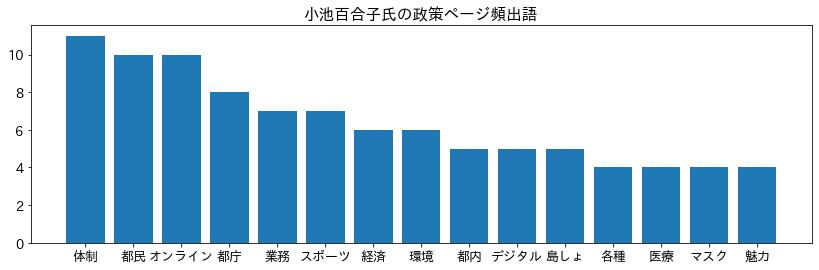

In [45]:
# データを変数に格納
x1 = K_df[0]
y1 = K_df[1]
 
# グラフのサイズ、ラベルの文字サイズを指定
fig = plt.figure(figsize=(14.0,4.0))
fig = plt.rcParams["font.size"]=13
 
# 棒グラフで図示
plt.title("小池百合子氏の政策ページ頻出語")
plt.bar(x1,y1)

In [21]:
# テキストデータの読み込み
meros = r'./txt/meros.txt'
with open(meros) as m:
    m_txt = m.read()
print(m_txt)

メロスは激怒した。必ず、かの邪智暴虐の王を除かなければならぬと決意した。メロスには政治がわからぬ。メロスは、村の牧人である。笛を吹き、羊と遊んで暮して来た。けれども邪悪に対しては、人一倍に敏感であった。きょう未明メロスは村を出発し、野を越え山越え、十里はなれた此のシラクスの市にやって来た。メロスには父も、母も無い。女房も無い。十六の、内気な妹と二人暮しだ。この妹は、村の或る律気な一牧人を、近々、花婿として迎える事になっていた。結婚式も間近かなのである。メロスは、それゆえ、花嫁の衣裳やら祝宴の御馳走やらを買いに、はるばる市にやって来たのだ。先ず、その品々を買い集め、それから都の大路をぶらぶら歩いた。メロスには竹馬の友があった。セリヌンティウスである。今は此のシラクスの市で、石工をしている。その友を、これから訪ねてみるつもりなのだ。久しく逢わなかったのだから、訪ねて行くのが楽しみである。歩いているうちにメロスは、まちの様子を怪しく思った。ひっそりしている。もう既に日も落ちて、まちの暗いのは当りまえだが、けれども、なんだか、夜のせいばかりでは無く、市全体が、やけに寂しい。のんきなメロスも、だんだん不安になって来た。路で逢った若い衆をつかまえて、何かあったのか、二年まえに此の市に来たときは、夜でも皆が歌をうたって、まちは賑やかであった筈だが、と質問した。若い衆は、首を振って答えなかった。しばらく歩いて老爺に逢い、こんどはもっと、語勢を強くして質問した。老爺は答えなかった。メロスは両手で老爺のからだをゆすぶって質問を重ねた。老爺は、あたりをはばかる低声で、わずか答えた。



In [30]:
import re
import MeCab

# dockerで最新語彙対応辞書「mecab-ipadic-NEologd」をgit cloneとインストール済みのため、
# 下記コードでMeCabがmecab-ipadic-NEologdにアクセスできるよう、パスを通す。
import subprocess
cmd='echo `mecab-config --dicdir`"/mecab-ipadic-neologd"'
path = (subprocess.Popen(cmd, stdout=subprocess.PIPE,
shell=True).communicate()[0]).decode('utf-8')
mecab=MeCab.Tagger("-d {0}".format(path))


m_parsed = mecab.parse(m_txt)
print(m_parsed)

メロス	名詞,固有名詞,一般,*,*,*,メロス,メロス,メロス
は	助詞,係助詞,*,*,*,*,は,ハ,ワ
激怒	名詞,サ変接続,*,*,*,*,激怒,ゲキド,ゲキド
し	動詞,自立,*,*,サ変・スル,連用形,する,シ,シ
た	助動詞,*,*,*,特殊・タ,基本形,た,タ,タ
。	記号,句点,*,*,*,*,。,。,。
必ず	副詞,助詞類接続,*,*,*,*,必ず,カナラズ,カナラズ
、	記号,読点,*,*,*,*,、,、,、
かの	連体詞,*,*,*,*,*,かの,カノ,カノ
邪智	名詞,一般,*,*,*,*,邪智,ジャチ,ジャチ
暴虐	名詞,一般,*,*,*,*,暴虐,ボウギャク,ボーギャク
の	助詞,連体化,*,*,*,*,の,ノ,ノ
王	名詞,一般,*,*,*,*,王,オウ,オー
を	助詞,格助詞,一般,*,*,*,を,ヲ,ヲ
除か	動詞,自立,*,*,五段・カ行イ音便,未然形,除く,ノゾカ,ノゾカ
なけれ	助動詞,*,*,*,特殊・ナイ,仮定形,ない,ナケレ,ナケレ
ば	助詞,接続助詞,*,*,*,*,ば,バ,バ
なら	動詞,非自立,*,*,五段・ラ行,未然形,なる,ナラ,ナラ
ぬ	助動詞,*,*,*,特殊・ヌ,基本形,ぬ,ヌ,ヌ
と	助詞,格助詞,引用,*,*,*,と,ト,ト
決意	名詞,サ変接続,*,*,*,*,決意,ケツイ,ケツイ
し	動詞,自立,*,*,サ変・スル,連用形,する,シ,シ
た	助動詞,*,*,*,特殊・タ,基本形,た,タ,タ
。	記号,句点,*,*,*,*,。,。,。
メロス	名詞,固有名詞,一般,*,*,*,メロス,メロス,メロス
に	助詞,格助詞,一般,*,*,*,に,ニ,ニ
は	助詞,係助詞,*,*,*,*,は,ハ,ワ
政治	名詞,一般,*,*,*,*,政治,セイジ,セイジ
が	助詞,格助詞,一般,*,*,*,が,ガ,ガ
わから	動詞,自立,*,*,五段・ラ行,未然形,わかる,ワカラ,ワカラ
ぬ	助動詞,*,*,*,特殊・ヌ,基本形,ぬ,ヌ,ヌ
。	記号,句点,*,*,*,*,。,。,。
メロス	名詞,固有名詞,一般,*,*,*,メロス,メロス,メロス
は	助詞,係助詞,*,*,*,*,は,ハ,ワ
、	記号,読点,*,*,*,*,、,、,、
村	名詞,一般,*,*,*,*,村,ムラ,ムラ
の	助詞,連体化,*,*,*,*,

In [31]:
#行単位に分割
m_parsed_lines = m_parsed.split('\n')
 
#処理に使うリストを作成
m_parsed_words = []
m_words = []
 
#各行のタブ（\t）を除去
for m_parsed_line in m_parsed_lines:
    m_parsed_words.append(re.split('[\t,]', m_parsed_line))
 
# 名詞・一般に該当する単語をリストに格納
for m_parsed_word in m_parsed_words:
    if (m_parsed_word[0] not in ('EOS', '') and m_parsed_word[1] == '名詞' \
        or m_parsed_word[0] not in ('EOS', '') and m_parsed_word[1] == '動詞'):
        
        m_words.append(m_parsed_word[0])
print(m_words)

['メロス', '激怒', 'し', '邪智', '暴虐', '王', '除か', 'なら', '決意', 'し', 'メロス', '政治', 'わから', 'メロス', '村', '牧人', '笛', '吹き', '羊', '遊ん', '暮し', '来', '邪悪', '人一倍', '敏感', 'きょう', '未明', 'メロス', '村', '出発', 'し', '野', '越え', '山越え', '十里', 'なれ', '此', 'シラクス', '市', 'やって来', 'メロス', '父', '母', '女房', '十六', '内気', '妹', '二人暮し', '妹', '村', '律', '気', '一', '牧人', '花婿', '迎える', '事', 'なっ', 'い', '結婚式', 'の', 'メロス', 'それ', 'ゆえ', '花嫁', '衣裳', '祝宴', '御馳走', '買い', '市', 'やって来', 'の', '品々', '買い', '集め', '都', '大路', '歩い', 'メロス', '竹馬の友', 'あっ', 'セリヌンティウス', '今', '此', 'シラクス', '市', '石工', 'し', 'いる', '友', '訪ね', 'みる', 'つもり', 'の', '逢わ', 'の', '訪ね', '行く', 'の', '楽しみ', '歩い', 'いる', 'うち', 'メロス', 'まち', '様子', '思っ', 'し', 'いる', '日', '落ち', 'まち', 'の', '当りまえ', '夜', 'せい', '市', '全体', 'のんき', 'メロス', '不安', 'なっ', '来', '路', '逢っ', '若い衆', 'つかまえ', '何', 'あっ', 'の', '二', '年', 'まえ', '此', '市', '来', 'とき', '夜', '皆', '歌', 'うたっ', 'まち', '賑やか', '筈', '質問', 'し', '若い衆', '首', '振っ', '答え', '歩い', '老爺', '逢い', 'こんど', '語勢', 'し', '質問', 'し', '老爺', '答え', 'メロス', '両手', '老爺', 'からだ', 'ゆすぶっ', '質問', '重ね', '老爺

### 単語の集合データに変換

更なる分析のために語順を考慮するか、しないかを決める。  
基準はこの後にしたい事が語順を必要としているかどうかで決める。  
語順を考慮する場合には、構文解析を行う。（syntaxNetなど）  

考慮しないデータ形式をbag of wordsと呼ぶ。  
下記コードで実践。

In [32]:
import MeCab
corpus = [
    "私はラーメンが好きです。",
    "私は餃子が好きです。",
    "私はラーメンが大嫌いです。"
]

tagger = MeCab.Tagger('-Owakati')
corpus = [tagger.parse(sentence).strip() for sentence in m_txt]

print(*corpus, sep="\n")

メ
ロ
ス
は
激
怒
し
た
。
必
ず
、
か
の
邪
智
暴
虐
の
王
を
除
か
な
け
れ
ば
な
ら
ぬ
と
決
意
し
た
。
メ
ロ
ス
に
は
政
治
が
わ
か
ら
ぬ
。
メ
ロ
ス
は
、
村
の
牧
人
で
あ
る
。
笛
を
吹
き
、
羊
と
遊
ん
で
暮
し
て
来
た
。
け
れ
ど
も
邪
悪
に
対
し
て
は
、
人
一
倍
に
敏
感
で
あ
っ
た
。
き
ょ
う
未
明
メ
ロ
ス
は
村
を
出
発
し
、
野
を
越
え
山
越
え
、
十
里
は
な
れ
た
此
の
シ
ラ
ク
ス
の
市
に
や
っ
て
来
た
。
メ
ロ
ス
に
は
父
も
、
母
も
無
い
。
女
房
も
無
い
。
十
六
の
、
内
気
な
妹
と
二
人
暮
し
だ
。
こ
の
妹
は
、
村
の
或
る
律
気
な
一
牧
人
を
、
近
々
、
花
婿
と
し
て
迎
え
る
事
に
な
っ
て
い
た
。
結
婚
式
も
間
近
か
な
の
で
あ
る
。
メ
ロ
ス
は
、
そ
れ
ゆ
え
、
花
嫁
の
衣
裳
や
ら
祝
宴
の
御
馳
走
や
ら
を
買
い
に
、
は
る
ば
る
市
に
や
っ
て
来
た
の
だ
。
先
ず
、
そ
の
品
々
を
買
い
集
め
、
そ
れ
か
ら
都
の
大
路
を
ぶ
ら
ぶ
ら
歩
い
た
。
メ
ロ
ス
に
は
竹
馬
の
友
が
あ
っ
た
。
セ
リ
ヌ
ン
テ
ィ
ウ
ス
で
あ
る
。
今
は
此
の
シ
ラ
ク
ス
の
市
で
、
石
工
を
し
て
い
る
。
そ
の
友
を
、
こ
れ
か
ら
訪
ね
て
み
る
つ
も
り
な
の
だ
。
久
し
く
逢
わ
な
か
っ
た
の
だ
か
ら
、
訪
ね
て
行
く
の
が
楽
し
み
で
あ
る
。
歩
い
て
い
る
う
ち
に
メ
ロ
ス
は
、
ま
ち
の
様
子
を
怪
し
く
思
っ
た
。
ひ
っ
そ
り
し
て
い
る
。
も
う
既
に
日
も
落
ち
て
、
ま
ち
の
暗
い
の
は
当
り
ま
え
だ
が
、
け
れ
ど
も
、
な
ん
だ
か
、
夜
の
せ
い
ば
か
り
で
は
無
く
、
市
全
体
が
、
や
け
に
寂
し
い
。
の
ん
き
な
メ
ロ
ス
も
、
だ


In [33]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(token_pattern=u'(?u)\\b\\w+\\b')
bag = vectorizer.fit_transform(corpus)
print(bag.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [34]:
print(vectorizer.vocabulary_)

{'メ': 56, 'ロ': 59, 'ス': 52, 'は': 30, '激': 138, '怒': 107, 'し': 11, 'た': 16, '必': 106, 'ず': 13, 'か': 5, 'の': 29, '邪': 175, '智': 122, '暴': 125, '虐': 158, '王': 143, 'を': 46, '除': 181, 'な': 25, 'け': 9, 'れ': 44, 'ば': 31, 'ら': 41, 'ぬ': 27, 'と': 23, '決': 136, '意': 111, 'に': 26, '政': 117, '治': 137, 'が': 6, 'わ': 45, '村': 127, '牧': 142, '人': 67, 'で': 22, 'あ': 1, 'る': 43, '笛': 149, '吹': 81, 'き': 7, '羊': 153, '遊': 174, 'ん': 47, '暮': 124, 'て': 21, '来': 128, 'ど': 24, 'も': 37, '悪': 110, '対': 96, '一': 61, '倍': 72, '敏': 118, '感': 112, 'っ': 19, 'ょ': 40, 'う': 3, '未': 126, '明': 121, '出': 77, '発': 144, '野': 179, '越': 169, 'え': 4, '山': 97, '十': 79, '里': 177, '此': 132, 'シ': 51, 'ラ': 57, 'ク': 50, '市': 99, 'や': 38, '父': 140, '母': 134, '無': 139, 'い': 2, '女': 87, '房': 114, '六': 75, '内': 76, '気': 135, '妹': 88, '二': 66, 'だ': 17, 'こ': 10, '或': 113, '律': 104, '近': 172, '々': 0, '花': 155, '婿': 90, '迎': 171, '事': 65, '結': 152, '婚': 89, '式': 101, '間': 180, 'そ': 15, 'ゆ': 39, '嫁': 91, '衣': 161, '裳': 162, '祝': 147, '宴': 94,

In [41]:
import os
from natto import MeCab
# bug of wordsを作成するためのライブラリ読み込み
from gensim import corpora, matutils

mc = MeCab()
txt_word_list = []

# テキストファイルを格納しているフォルダを読み込み
files = os.listdir(os.path.dirname(__file__)+'/path/txt')

# フォルダ配下のテキストファイルを1つずつ読み込み
for file in files:
  # テキストファイルから名詞と動詞の単語を取り出したリスト作成（Q11-1の処理と同じ）
  with open(os.path.dirname(__file__) + '/path/txt/'+file, 'r') as f:
    txt = f.read()
    word_list = []
    for n in mc.parse(txt, as_nodes=True):
      if not (n.is_bos() or n.is_eos()):
        part, word = n.feature.split(',', 1)
      if part == "名詞" or part == "動詞":
        word_list.append(n.surface)

  # テキストファイルごとの単語リストを追加
  txt_word_list.append(word_list)

# bug of wordsを作成するため全種類の単語を把握し、単語IDを付与した辞書を作成
corpus_dic = corpora.Dictionary(txt_word_list)

# 各文章の単語リストをコーパス（辞書の単語IDと単語の出現回数）リストに変換
corpus_list = [corpus_dic.doc2bow(word_in_text) for word_in_text in txt_word_list]

# コーパスリストをスパースマトリックス（csc型）に変換
word_matrix = matutils.corpus2csc(corpus_list)


ImportError: cannot import name 'escape' from 'cgi' (/opt/conda/lib/python3.8/cgi.py)

In [40]:
ls

txt/  Untitled1.ipynb  Untitled.ipynb  Yuriko_Koike_Policy.txt


In [37]:
from gensim import corpora, matutils

txt_word_list = []

files = os.listdir(os.path.dirname(__file__) + '/path/txt')

# 第十二章 位置情報型

位置情報は日本独自の表示方法と世界基準があり、GoogleMapは世界基準仕様のWGS84を基準にしている。  
緯度と軽度の表現は、60進法で表現されており、度=60分=60秒と表現される。30.25分は0.504(30.25/60)度です。

In [35]:
from pyproj import Transformer
customer = customer_master.copy()

def convert_to_cntinous(x):
    x_min = (x * 100 - int(x * 100)) * 100
    x_sec = (x - int(x) - x_min / 10000) * 100
    return int(x) + x_sec / 60 + x_min / 60 / 60

# 緯度
customer["home_latitude_new"] = customer["home_latitude"] \
  .apply(lambda x : convert_to_cntinous(x))

# 経度
customer["home_longitude_new"] = customer["home_longitude"] \
  .apply(lambda x : convert_to_cntinous(x))

epsg4301_to_epsg4326  = Transformer.from_crs("EPSG:4301", "EPSG:4326")

home_position = customer[["home_latitude_new", "home_longitude_new"]]\
  .apply(lambda x: epsg4301_to_epsg4326.transform(x[0], x[1]), axis=1)

customer["home_longitude_epsg4326"] = [x[0] for x in home_position]
customer["home_latitude_epsg4326"] = [x[1] for x in home_position]

In [36]:
customer.head()

,customer_id,age,sex,home_latitude,home_longitude,home_latitude_new,home_longitude_new,home_longitude_epsg4326,home_latitude_epsg4326
0,c_1,41,man,35.092193,136.512347,35.156092,136.856519,35.159315,136.853555
1,c_2,38,man,35.325076,139.410551,35.547433,139.684864,35.550685,139.681642
2,c_3,49,woman,35.120543,136.511179,35.201508,136.853275,35.204727,136.850310
3,c_4,43,man,43.034868,141.240314,43.063522,141.400872,43.065946,141.397126
4,c_5,31,man,35.102661,136.523797,35.174058,136.877214,35.177280,136.874247


In [108]:
hotel = pd.read_csv("./awesomebook/data/hotel.csv")
hotel_tb = hotel.copy()
hotel_tb.head()

reserve_tb = reserve_master.copy()
customer_tb = customer_master.copy()

In [125]:
import math
import pyproj
import geopy
# 二点間の距離を求める。
from vincenty import vincenty
from geopy.distance import great_circle

reserve = reserve_tb.merge(customer_tb, on="customer_id", how="inner")
reserve = reserve.merge(hotel_tb, on="hotel_id", how="inner")

# 家とホテルの情報を取得
home_and_hotel_point = reserve.loc[:, ["home_longitude", "home_latitude", "hotel_longitude", "hotel_latitude"]]
g = pyproj.Geod(ellps="WGS84")

# 方位角、反方位角、vincenty式による距離の計算
home_to_hotel = home_and_hotel_point.apply(lambda x: g.inv(x[0], x[1], x[2],x[3]), axis=1)
[x[0] for x in home_to_hotel]
[x[2] for x in home_to_hotel]

# great_circleの距離計算
reserve["距離"] = home_and_hotel_point.apply(lambda x: great_circle((x[1], x[0]), (x[3], x[2])).meters, axis=1)
reserve

# Vincentｙの距離計算
# reserve["距離"] = home_and_hotel_point.apply(lambda x: vincenty((x[1], x[0]), (x[3], x[2])), axis=1)
# reserve

# hubenyの距離計算
# def hubeny(lon1, lat1, lon2, lat2, a = 6378137, b = 6356752.31425):
#     e2 = (a ** 2 - b ** 2) / a ** 2
#     (lon1, lat1, lon2, lat2) = \
#     [x * (2* math.pi) / 360 for x in (lon1, lat1, lon2, lat2)]
#     w= 1- e2 * math.sin((lat1 + lat2) / 2) ** 2
#     c2 = math.cos((lat1 + lat2) / 2) ** 2
#     return math.sqrt((b ** 2 / w ** 3) * (lat1 - lat2) ** 2 +
#                     (a ** 2 / w) * c2 * (lon1 - lon2) ** 2)
# reserve["距離"] = home_and_hotel_point.apply(lambda x: hubeny(x[0], x[1], x[2], x[3]),axis=1)
# reserve

,reserve_id,hotel_id,customer_id,reserve_datetime,checkin_date,checkin_time,checkout_date,people_num,total_price,age,sex,home_latitude,home_longitude,base_price,big_area_name,small_area_name,hotel_latitude,hotel_longitude,is_business,距離
0,r1,h_75,c_1,2016-03-06 13:09:42,2016-03-26,10:00:00,2016-03-29,4,97200,41,man,35.092193,136.512347,8100,B,B-2,35.54586,139.701217,False,293674.138580
1,r185,h_75,c_43,2016-03-23 06:27:35,2016-04-07,09:00:00,2016-04-10,4,97200,51,man,34.295938,132.294760,8100,B,B-2,35.54586,139.701217,False,689244.973432
2,r334,h_75,c_77,2016-08-17 19:29:12,2016-09-10,11:00:00,2016-09-13,1,24300,65,woman,38.192613,140.503229,8100,B,B-2,35.54586,139.701217,False,302825.904882
3,r783,h_75,c_191,2016-01-12 21:48:20,2016-01-22,12:30:00,2016-01-24,3,48600,71,woman,35.103054,136.503423,8100,B,B-2,35.54586,139.701217,False,294248.087929
4,r1276,h_75,c_311,2016-01-23 08:29:32,2016-02-05,12:00:00,2016-02-07,4,64800,42,woman,35.454241,139.460500,8100,B,B-2,35.54586,139.701217,False,24054.875110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4025,r3438,h_281,c_858,2017-03-16 12:48:56,2017-04-03,11:00:00,2017-04-04,3,47700,49,woman,34.445020,135.371007,15900,F,F-4,34.63673,132.569108,True,257512.006863
4026,r3441,h_281,c_858,2018-01-12 19:58:51,2018-01-22,11:30:00,2018-01-24,1,31800,49,woman,34.445020,135.371007,15900,F,F-4,34.63673,132.569108,True,257512.006863
4027,r3465,h_281,c_863,2018-07-12 04:18:50,2018-08-04,09:30:00,2018-08-06,1,31800,68,woman,38.170388,140.450993,15900,F,F-4,34.63673,132.569108,True,807022.468655
4028,r3787,h_281,c_942,2016-07-31 13:33:15,2016-08-27,09:00:00,2016-08-28,1,15900,66,man,35.131734,136.504505,15900,F,F-4,34.63673,132.569108,True,363134.633630
